🧠 Day 3 – SQL via Python: NYC School Data Exploration


# 🔌 Step 1: Import Libraries

In [47]:
import pandas as pd
import psycopg2

# 🔐 Step 2: Connect to the Database

In [48]:
# DB connection setup using hardcoded credentials (for onboarding only)
conn = psycopg2.connect(
    dbname="neondb",
    user="neondb_owner",
    password="npg_CeS9fJg2azZD",
    host="ep-falling-glitter-a5m0j5gk-pooler.us-east-2.aws.neon.tech",
    port="5432",
    sslmode="require"
)
cur = conn.cursor()

# 🔍 Step 3: Run a Test Query

In [23]:
query = "SELECT * FROM nyc_schools.high_school_directory LIMIT 5;"
df = pd.read_sql(query, conn)
df.head()

/tmp/ipython-input-1731849884.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,dbn,school_name,borough,building_code,phone_number,fax_number,grade_span_min,grade_span_max,expgrade_span_min,expgrade_span_max,...,number_programs,Location 1,Community Board,Council District,Census Tract,Zip Codes,Community Districts,Borough Boundaries,City Council Districts,Police Precincts
0,27Q260,Frederick Douglass Academy VI High School,Queens,Q465,718-471-2154,718-471-2890,9.0,12,None,None,...,1,"{'latitude': '40.601989336', 'longitude': '-73...",14,31,100802,20529,51,3,47,59
1,21K559,Life Academy High School for Film and Music,Brooklyn,K400,718-333-7750,718-333-7775,9.0,12,None,None,...,1,"{'latitude': '40.593593811', 'longitude': '-73...",13,47,306,17616,21,2,45,35
2,16K393,Frederick Douglass Academy IV Secondary School,Brooklyn,K026,718-574-2820,718-574-2821,9.0,12,None,None,...,1,"{'latitude': '40.692133704', 'longitude': '-73...",3,36,291,18181,69,2,49,52
3,08X305,Pablo Neruda Academy,Bronx,X450,718-824-1682,718-824-1663,9.0,12,None,None,...,1,"{'latitude': '40.822303765', 'longitude': '-73...",9,18,16,11611,58,5,31,26
4,03M485,Fiorello H. LaGuardia High School of Music & A...,Manhattan,M485,212-496-0700,212-724-5748,9.0,12,None,None,...,6,"{'latitude': '40.773670507', 'longitude': '-73...",7,6,151,12420,20,4,19,12


# Step 4: 💻 Data Exploration

In [24]:

pd.read_sql("""
SELECT table_schema, table_name
FROM information_schema.tables
WHERE table_schema NOT IN ('pg_catalog','information_schema')
ORDER BY 1,2;
""", conn)

/tmp/ipython-input-2616290920.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql("""


,table_schema,table_name
0,dependency_example,banks_test_kovalivska_aws
1,dependency_example,departments
2,dependency_example,districts
3,dependency_example,employees
4,dependency_example,martin_svitek_sat_results
...,...,...
73,test_berlin_data,smart_banks_test_6802_9949
74,test_berlin_data,ubahn
75,test_berlin_data,users_test
76,test_berlin_data,v3_test_table


In [25]:
# Example: Count schools by borough
query = """
SELECT borough, COUNT(*) AS school_count
FROM nyc_schools.high_school_directory
GROUP BY borough;
"""
df_result = pd.read_sql(query, conn)
df_result

/tmp/ipython-input-3450537001.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_result = pd.read_sql(query, conn)


,borough,school_count
0,Brooklyn,121
1,Queens,80
2,Staten Island,10
3,Manhattan,106
4,Bronx,118


# Step 5: ✅ Task Queries

## 🧮 School Distribution — how many schools per borough

In [27]:
q1 = pd.read_sql("""
SELECT borough, COUNT(DISTINCT dbn) AS unique_schools
FROM nyc_schools.high_school_directory
GROUP BY 1
ORDER BY 2 DESC;
""", conn)

q1

/tmp/ipython-input-4260361638.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  q1 = pd.read_sql("""


,borough,unique_schools
0,Brooklyn,121
1,Bronx,118
2,Manhattan,106
3,Queens,80
4,Staten Island,10


- Bar plot for Q1

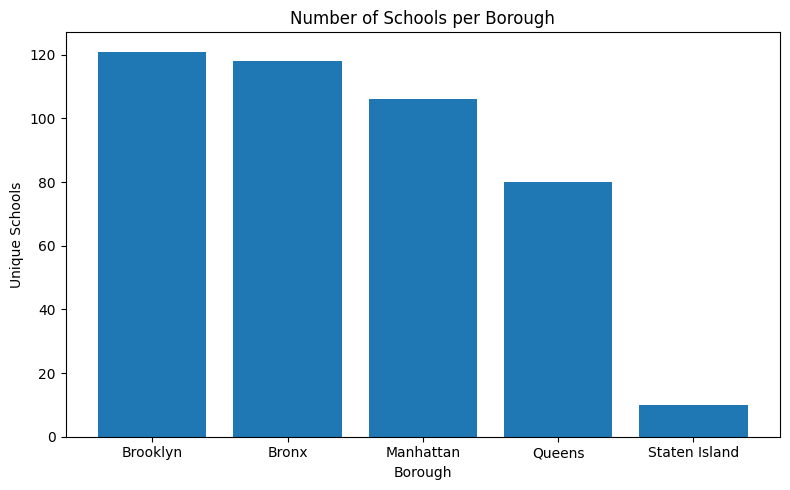

In [28]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8,5))
plt.bar(q1["borough"], q1["unique_schools"])
plt.title("Number of Schools per Borough")
plt.xlabel("Borough")
plt.ylabel("Unique Schools")
plt.tight_layout()
plt.show()

## 🎓 Average % of ELL per borough

In [34]:
q2_latest = pd.read_sql("""
SELECT h.borough,
       ROUND(AVG(sd.ell_percent::numeric), 2) AS avg_ell_percent,
       COUNT(sd.ell_percent) AS schools_used
FROM nyc_schools.high_school_directory h
LEFT JOIN nyc_schools.school_demographics sd ON sd.dbn = h.dbn
GROUP BY h.borough
ORDER BY avg_ell_percent DESC NULLS LAST;

""", conn)

q2_latest

/tmp/ipython-input-3321548881.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  q2_latest = pd.read_sql("""


,borough,avg_ell_percent,schools_used
0,Manhattan,7.57,40
1,Brooklyn,NaN,0
2,Queens,NaN,0
3,Staten Island,NaN,0
4,Bronx,NaN,0


How many boroughs are there ?

In [35]:
pd.read_sql("""
SELECT DISTINCT borough
FROM nyc_schools.high_school_directory
ORDER BY 1;
""", conn)

/tmp/ipython-input-2598525865.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql("""


,borough
0,Bronx
1,Brooklyn
2,Manhattan
3,Queens
4,Staten Island


Coverage check

In [46]:
pd.read_sql("""
SELECT
  h.borough,
  COUNT(DISTINCT h.dbn) AS directory_schools,
  COUNT(DISTINCT sd.dbn) AS schools_with_demographics
FROM nyc_schools.high_school_directory h
LEFT JOIN nyc_schools.school_demographics sd
  ON sd.dbn = h.dbn
  GROUP BY h.borough
  ORDER BY 1;
""", conn)

/tmp/ipython-input-2197057282.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql("""


,borough,directory_schools,schools_with_demographics
0,Bronx,118,0
1,Brooklyn,121,0
2,Manhattan,106,7
3,Queens,80,0
4,Staten Island,10,0


- Bar plot for Q2

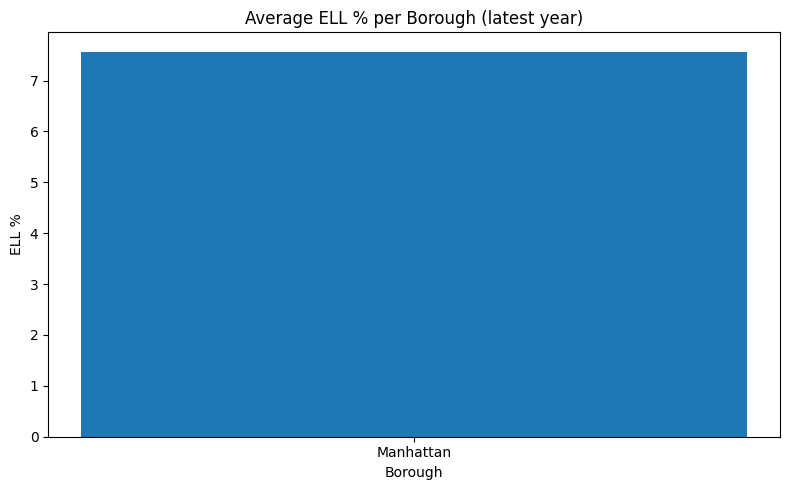

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(q2_latest["borough"], q2_latest["avg_ell_percent"])
plt.title("Average ELL % per Borough (latest year)")
plt.xlabel("Borough")
plt.ylabel("ELL %")
plt.tight_layout()
plt.show()

## 🔗 Top 3 schools per borough by sped_percent

In [54]:
q3 = pd.read_sql("""
WITH ranked_schools AS (
  SELECT
      sch.dbn,
      sch.school_name,
      sch.borough,
      dem.schoolyear,
      dem.sped_percent::numeric AS sped_percent,
      ROW_NUMBER() OVER (
        PARTITION BY sch.borough
        ORDER BY dem.sped_percent::numeric DESC
      ) AS rn
  FROM nyc_schools.high_school_directory AS sch
  JOIN nyc_schools.school_demographics AS dem
    ON sch.dbn = dem.dbn
  WHERE dem.sped_percent IS NOT NULL
)
SELECT borough, dbn, school_name, schoolyear, sped_percent
FROM ranked_schools
WHERE rn <= 3
ORDER BY borough, sped_percent DESC, school_name;
""",conn)

q3

/tmp/ipython-input-842109259.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  q3 = pd.read_sql("""


,borough,dbn,school_name,schoolyear,sped_percent
0,Manhattan,01M450,East Side Community School,20092010,28.8
1,Manhattan,01M450,East Side Community School,20102011,27.7
2,Manhattan,01M450,East Side Community School,20082009,26.7


Plot for Q3

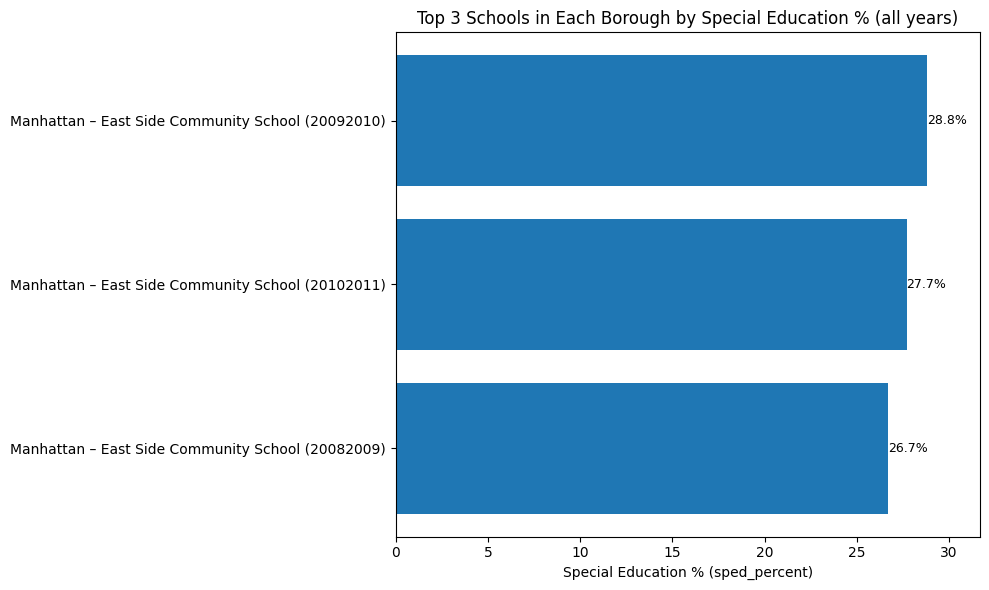

In [55]:
import matplotlib.pyplot as plt
import numpy as np

# Sort within borough by sped_percent desc and build readable labels
q3_plot = q3.sort_values(['borough', 'sped_percent'], ascending=[True, False]).copy()
q3_plot['label'] = (
    q3_plot['borough'] + ' – ' + q3_plot['school_name'] + ' (' + q3_plot['schoolyear'].astype(str) + ')'
)

n = len(q3_plot)
plt.figure(figsize=(10, max(6, 0.4 * n + 1)))

y = np.arange(n)
plt.barh(y, q3_plot['sped_percent'])
plt.yticks(y, q3_plot['label'])
plt.xlabel('Special Education % (sped_percent)')
plt.title('Top 3 Schools in Each Borough by Special Education % (all years)')
plt.gca().invert_yaxis()  # highest at the top

# Nice margins + annotations
max_val = float(q3_plot['sped_percent'].max())
plt.xlim(0, max_val * 1.1)
for i, v in enumerate(q3_plot['sped_percent']):
    plt.text(v, i, f"{v:.1f}%", va='center', ha='left', fontsize=9)

# Optional: faint separators between borough groups
boundaries = []
cursor = 0
for b in q3_plot['borough'].unique():
    cnt = (q3_plot['borough'] == b).sum()
    cursor += cnt
    boundaries.append(cursor - 0.5)
for yline in boundaries[:-1]:
    plt.axhline(y=yline, linewidth=1, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


# Step 6: 🧠 Insights

- School distribution: Brooklyn (121), Bronx (118), Manhattan (106), Queens (80), Staten Island (10).

- ELL : Only Manhattan has demographics rows in this training DB → Manhattan avg ELL ≈ 7.57% (other boroughs: no data).

- Special education : Only Manhattan East Side Community School returns results. Top three by SPED% are different school years :

a) 2009-2010 — 28.8%

b) 2010-2011 — 27.7%

c) 2008-2009 — 26.7%